### Planning

Goal: Why are our customers churning?

*Specific questions to address*
- Does the month they signed up influence churn? 
    - plot the rate of churn on a line chart, where x is tenure and y is the customers churned/total customers
- Which, if any, features indicate a higher liklihood of churn?
- Is there a price threshold for likelihood of churn, specific to services? What is that point?
- What is the churn rate in the 13th month for one-year customers compared to month-to-month customers?

Data Dictionary - features that were included
- senior_citizen: is the person a senior citizen, exact age is unknown
- tenure: how long a person has been with the company
- payment_type: how a person pays their monthly bill
- online_additions: combined online security and online backup
- monthly_charges: the charge a person paid per month
- total_charges: the total amount a person has paid over their tenure


Starting hypothesis: Contract type, monthly charges, and internet type will be most effective in predicting a model

## Acquire

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import export_graphviz
from graphviz import Source

import acquire
import prep
import split_scale
import model

import warnings 
warnings.filterwarnings("ignore")

In [2]:
# get telco data from mysql with all tables joined
df = acquire.get_telco_data()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
payment_type_id             7043 non-null int64
contract_type_id            7043 non-null int64
internet_service_type_id    7043 non-null int64
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
paperless_billing           7043 non-null object
monthly_charges 

In [4]:
df.describe()

,payment_type_id,contract_type_id,internet_service_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2.315633,1.690473,1.872923,0.162147,32.371149,64.761692
std,1.148907,0.833755,0.737796,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,1.000000,2.000000,0.000000,29.000000,70.350000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000


In [5]:
# no nulls were found!
df.isnull().sum()

payment_type_id             0
contract_type_id            0
internet_service_type_id    0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
internet_service_type       0
contract_type               0
payment_type                0
dtype: int64

In [6]:
df.head()

,payment_type_id,contract_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,DSL,Month-to-month,Mailed check
1,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,...,Yes,Yes,Yes,Yes,69.4,571.45,No,DSL,Month-to-month,Credit card (automatic)
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,...,No,No,No,Yes,48.2,340.35,No,DSL,Month-to-month,Electronic check
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,...,No,No,No,Yes,25.1,25.1,Yes,DSL,Month-to-month,Electronic check
4,3,1,1,0032-PGELS,Female,0,Yes,Yes,1,No,...,No,No,No,No,30.5,30.5,Yes,DSL,Month-to-month,Bank transfer (automatic)


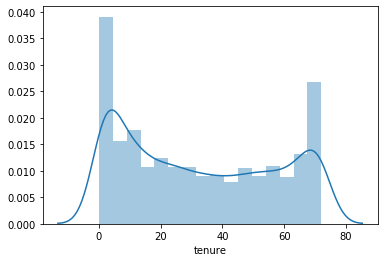

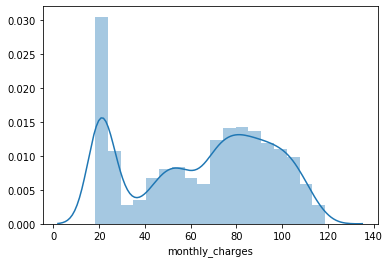

In [7]:
# check out the distribution of tenure and monthly charges
sns.distplot(df.tenure)
plt.show()
sns.distplot(df.monthly_charges)
plt.show()

In [8]:
# how many people have and have not churned
df.churn.value_counts()

No     5174
Yes    1869
Name: churn, dtype: int64

In [9]:
print("The average rate of churn is {:.2f}".format(1869/(1869+5163)))

The average rate of churn is 0.27


### Prepare - Baseline

In [10]:
# cleaned total_charges & changed to float
df = prep.clean_data(df)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 24 columns):
payment_type_id             7032 non-null int64
contract_type_id            7032 non-null int64
internet_service_type_id    7032 non-null int64
customer_id                 7032 non-null object
gender                      7032 non-null object
senior_citizen              7032 non-null int64
partner                     7032 non-null object
dependents                  7032 non-null object
tenure                      7032 non-null int64
phone_service               7032 non-null object
multiple_lines              7032 non-null object
online_security             7032 non-null object
online_backup               7032 non-null object
device_protection           7032 non-null object
tech_support                7032 non-null object
streaming_tv                7032 non-null object
streaming_movies            7032 non-null object
paperless_billing           7032 non-null object
monthly_charges 

In [12]:
# split data using a train of 80% and a default random state of 123
train, test = split_scale.split_my_data(df, .80)

In [13]:
# split features and target
X_train = train.drop(columns="churn")
X_test = train.drop(columns="churn")
y_train = train[["churn"]]
y_test = test[["churn"]]

In [14]:
# encode churn values from no/yes to 0/1
y_train, y_test = prep.encode(y_train, y_test, "churn")
y_train.info()
y_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5625 entries, 5474 to 3582
Data columns (total 1 columns):
churn    5625 non-null int64
dtypes: int64(1)
memory usage: 87.9 KB


,churn
5474,0
5426,0
3563,0
2096,0
7019,0


In [15]:
# remove all the non-numeric columns, so a baseline model can be created
X_train = X_train.select_dtypes(include = [int, float])
X_test = X_train.select_dtypes(include = [int, float])

In [16]:
X_train.info()
X_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5625 entries, 5474 to 3582
Data columns (total 7 columns):
payment_type_id             5625 non-null int64
contract_type_id            5625 non-null int64
internet_service_type_id    5625 non-null int64
senior_citizen              5625 non-null int64
tenure                      5625 non-null int64
monthly_charges             5625 non-null float64
total_charges               5625 non-null float64
dtypes: float64(2), int64(5)
memory usage: 351.6 KB


,payment_type_id,contract_type_id,internet_service_type_id,senior_citizen,tenure,monthly_charges,total_charges
5474,4,3,1,0,72,85.90,6110.75
5426,2,3,1,0,62,65.10,3846.75
3563,1,1,3,0,1,20.00,20.00
2096,3,1,2,0,33,70.40,2406.10
7019,2,3,3,0,56,24.45,1385.85


### Model - Baseline

In [17]:
# run decision tree! 
# random state set to 123
clf, y_pred, y_pred_proba = model.clf(X_train, y_train)

In [18]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print()
print("confustion matrix")
print(confusion_matrix(y_train, y_pred))
print()
print(classification_report(y_train, y_pred))

Accuracy of Decision Tree classifier on training set: 0.79

confustion matrix
[[3900  250]
 [ 931  544]]

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      4150
           1       0.69      0.37      0.48      1475

    accuracy                           0.79      5625
   macro avg       0.75      0.65      0.67      5625
weighted avg       0.78      0.79      0.77      5625



In [19]:
confusion_matrix(y_train, y_pred)

array([[3900,  250],
       [ 931,  544]])

In [20]:
# visualize
dot_data = export_graphviz(clf, out_file=None) 
graph = Source(dot_data) 

graph.render('telco_decision_tree', view=False)

'telco_decision_tree.pdf'

### Prepare - MVP 

In [21]:
# create new train and test for updated model
train1, test1 = split_scale.split_my_data(df, .80)

In [22]:
# encode churn value for plotting
train1, test1 = prep.encode(train1, test1, "churn")

In [23]:
# drop encoded columns
train1.drop(columns=["payment_type_id","contract_type_id","internet_service_type_id"], inplace=True)
test1.drop(columns=["payment_type_id","contract_type_id","internet_service_type_id"], inplace=True)

In [24]:
train1.info()
train1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5625 entries, 5474 to 3582
Data columns (total 21 columns):
customer_id              5625 non-null object
gender                   5625 non-null object
senior_citizen           5625 non-null int64
partner                  5625 non-null object
dependents               5625 non-null object
tenure                   5625 non-null int64
phone_service            5625 non-null object
multiple_lines           5625 non-null object
online_security          5625 non-null object
online_backup            5625 non-null object
device_protection        5625 non-null object
tech_support             5625 non-null object
streaming_tv             5625 non-null object
streaming_movies         5625 non-null object
paperless_billing        5625 non-null object
monthly_charges          5625 non-null float64
total_charges            5625 non-null float64
churn                    5625 non-null int64
internet_service_type    5625 non-null object
contract_type    

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
5474,2226-ICFDO,Female,0,Yes,Yes,72,Yes,Yes,Yes,No,...,Yes,Yes,Yes,Yes,85.90,6110.75,0,DSL,Two year,Credit card (automatic)
5426,1221-GHZEP,Female,0,No,No,62,Yes,No,Yes,No,...,Yes,No,Yes,Yes,65.10,3846.75,0,DSL,Two year,Mailed check
3563,3807-XHCJH,Female,0,Yes,Yes,1,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,20.00,20.00,0,None,Month-to-month,Electronic check
2096,4067-HLYQI,Female,0,No,No,33,Yes,No,No,No,...,No,No,No,Yes,70.40,2406.10,0,Fiber optic,Month-to-month,Bank transfer (automatic)
7019,9593-CVZKR,Female,0,Yes,Yes,56,Yes,Yes,No internet service,No internet service,...,No internet service,No internet service,No internet service,Yes,24.45,1385.85,0,None,Two year,Mailed check


### Explore - MVP

Q1: Could the month in which they signed up influence churn? i.e. if a cohort is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts? (Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers)

##### Explore tenure

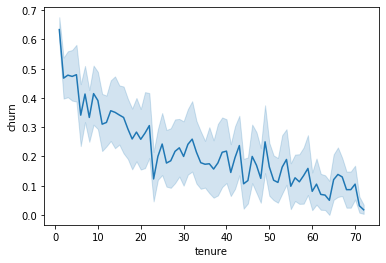

In [25]:
sns.lineplot(x="tenure", y="churn", data=train1)
plt.show()

> The highest churn rates happen in the beginning, specifically in the first month

Q2: Are there features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?

##### Explore payment types

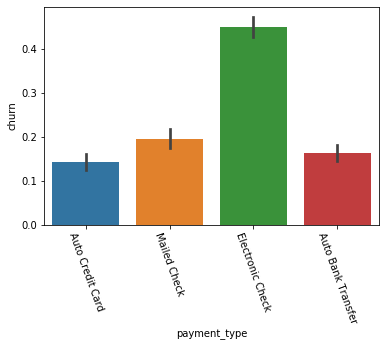

In [26]:
# plot payment types
fig = sns.barplot(x="payment_type", y="churn", data=train1)
fig.set_xticklabels(["Auto Credit Card", "Mailed Check","Electronic Check", "Auto Bank Transfer"])
plt.xticks(rotation=-70)
plt.show()

> Non-automatic payment types (mailed check and electronic check) have higher churn rates

##### Explore phone services

In [27]:
# multiple lines is redundant information of phone service, therefore, drop phone service column
print(train1.multiple_lines.value_counts())
print()
print(train1.phone_service.value_counts())

No                  2736
Yes                 2339
No phone service     550
Name: multiple_lines, dtype: int64

Yes    5075
No      550
Name: phone_service, dtype: int64


In [28]:
train1.drop(columns = "phone_service", inplace=True)
test1.drop(columns = "phone_service", inplace=True)

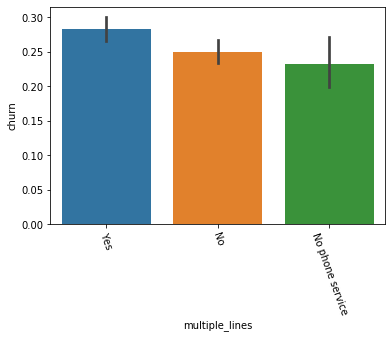

In [29]:
# plot phone type
sns.barplot(x="multiple_lines", y="churn", data=train1)
plt.xticks(rotation=-70)
plt.show()

> The phone service type minimally affects churn

##### Explore online services

H0: online security is indepedent of online backup

In [30]:
observed = pd.crosstab(train1.online_security,train1.online_backup)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print('Observed')
print(observed.values)
print('\nExpected')
print(expected)
print('')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[1756    0 1033]
 [   0 1232    0]
 [ 710    0  894]]

Expected
[[1222.6976      610.85297778  955.44942222]
 [ 540.1088      269.83537778  422.05582222]
 [ 703.1936      351.31164444  549.49475556]]

chi^2 = 5810.1221
p     = 0.0000


The p-value is zero, therefore, we reject the null hypothesis

In [31]:
print(train1.online_security.value_counts())
print()
print(train.online_backup.value_counts())

No                     2789
Yes                    1604
No internet service    1232
Name: online_security, dtype: int64

No                     2466
Yes                    1927
No internet service    1232
Name: online_backup, dtype: int64


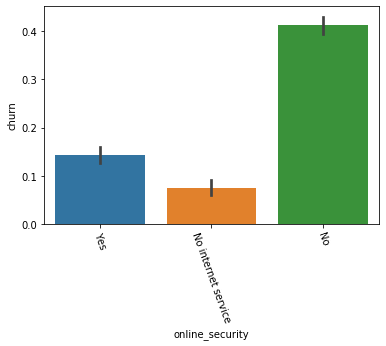

In [32]:
# plot online security
sns.barplot(x="online_security", y="churn", data=train1)
plt.xticks(rotation=-70)
plt.show()

> People with no online security are more likely to stay. Does the online security have an unreasonable price? Does having online security encourage folks to stay?

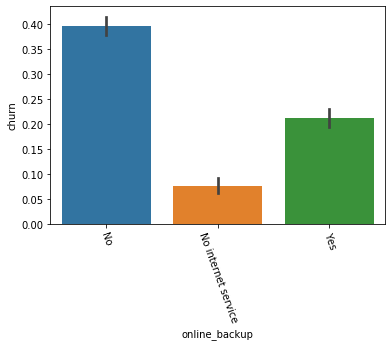

In [33]:
# plot online backup
sns.barplot(x="online_backup", y="churn", data=train1)
plt.xticks(rotation=-70)
plt.show()

> People without online backup are more likely to churn. Is our online backup too expensive and folks look for it elsewhere? Or does having this feature make them feel more secure and they are more likely to stay?

In [34]:
# make a new column combining online security and backup
conditions = [
    (train1.online_security == "No") & (train1.online_backup == "No"),
    (train1.online_security == "Yes") & (train1.online_backup == "No"),
    (train1.online_security == "No") & (train1.online_backup == "Yes"),
    (train1.online_security == "Yes") & (train1.online_backup == "Yes")]

choices = ['None', 'Security', 'Backup', 'Both']
train1['online_additions'] = np.select(conditions, choices, default='No internet')

# test data
conditions = [
    (test1.online_security == "No") & (test1.online_backup == "No"),
    (test1.online_security == "Yes") & (test1.online_backup == "No"),
    (test1.online_security == "No") & (test1.online_backup == "Yes"),
    (test1.online_security == "Yes") & (test1.online_backup == "Yes")]

choices = ['None', 'Security', 'Backup', 'Both']
test1['online_additions'] = np.select(conditions, choices, default='No internet')

In [35]:
# drop old online columns
train1.drop(columns=["online_security","online_backup"],inplace=True)
test1.drop(columns=["online_security","online_backup"],inplace=True)

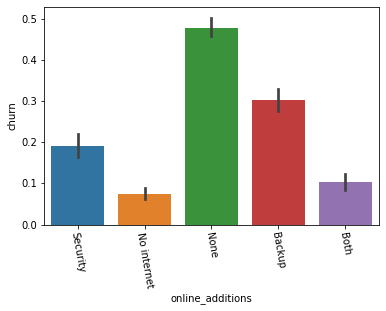

In [36]:
# plot all services 
sns.barplot(x="online_additions", y="churn", data=train1)
plt.xticks(rotation=-80)
plt.show()

> As seen earlier, it is shown that people without any online services are more likely to churn

##### Explore senior citizens

In [37]:
train1.senior_citizen.value_counts()

0    4729
1     896
Name: senior_citizen, dtype: int64

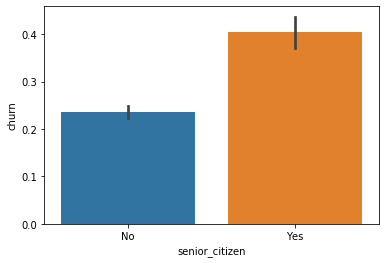

In [38]:
fig = sns.barplot(x="senior_citizen", y="churn", data=train1)
fig.set_xticklabels(["No","Yes"])
plt.show()

> Senior citizens have a higher churn rate than non-senior citizens.

##### Explore streaming services

H0: Streaming movies is indepedent of streaming tv

In [39]:
observed = pd.crosstab(train1.streaming_movies,train1.streaming_tv)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print('Observed')
print(observed.values)
print('\nExpected')
print(expected)
print('')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[1615    0  610]
 [   0 1232    0]
 [ 628    0 1540]]

Expected
[[887.23111111 487.32444444 850.44444444]
 [491.26684444 269.83537778 470.89777778]
 [864.50204444 474.84017778 828.65777778]]

chi^2 = 6695.4471
p     = 0.0000


The p-value is zero, therefore, we reject the null hypothesis

In [40]:
print(train1.streaming_movies.value_counts())
print()
print(train1.streaming_tv.value_counts())

No                     2225
Yes                    2168
No internet service    1232
Name: streaming_movies, dtype: int64

No                     2243
Yes                    2150
No internet service    1232
Name: streaming_tv, dtype: int64


In [41]:
# make a new column combining streaming services
conditions = [
    (train1.streaming_movies == "No") & (train1.streaming_tv == "No"),
    (train1.streaming_movies == "No") & (train1.streaming_tv == "Yes"),
    (train1.streaming_movies == "Yes") & (train1.streaming_tv == "No"),
    (train1.streaming_movies == "Yes") & (train1.streaming_tv == "Yes")]
    
choices = ['No streaming', 'One stream', 'One stream', 'Two streams']
train1['streaming'] = np.select(conditions, choices, default='No internet')

# apply to test data
conditions = [
    (test1.streaming_movies == "No") & (test1.streaming_tv == "No"),
    (test1.streaming_movies == "No") & (test1.streaming_tv == "Yes"),
    (test1.streaming_movies == "Yes") & (test1.streaming_tv == "No"),
    (test1.streaming_movies == "Yes") & (test1.streaming_tv == "Yes")]
    
choices = ['No streaming', 'One stream', 'One stream', 'Two streams']
test1['streaming'] = np.select(conditions, choices, default='No internet')

In [42]:
train1.streaming.value_counts()

No streaming    1615
Two streams     1540
One stream      1238
No internet     1232
Name: streaming, dtype: int64

In [43]:
# drop old streaming columns
train1.drop(columns=["streaming_movies","streaming_tv"], inplace=True)
test1.drop(columns=["streaming_movies","streaming_tv"], inplace=True)

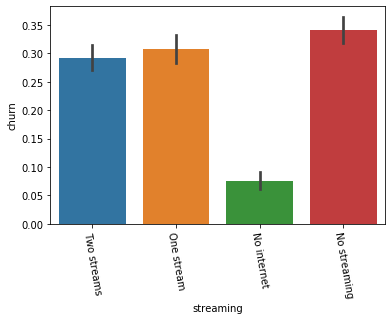

In [44]:
sns.barplot(x="streaming", y="churn", data=train1)
plt.xticks(rotation=-80)
plt.show()

> There is minimal difference in churn amoung streaming services

##### Explore family

In [45]:
# combine partner and dependents
conditions = [
    (train1.partner == "No") & (train1.dependents == "No"),
    (train1.partner == "No") & (train1.dependents == "Yes"),
    (train1.partner == "Yes") & (train1.dependents == "No"),
    (train1.partner == "Yes") & (train1.dependents == "Yes")]
    
choices = ['Single', 'Single with kids', 'Partner', 'Partner with kids']
train1['household'] = np.select(conditions, choices, default='Lost')

# apply to test data
conditions = [
    (test1.partner == "No") & (test1.dependents == "No"),
    (test1.partner == "No") & (test1.dependents == "Yes"),
    (test1.partner == "Yes") & (test1.dependents == "No"),
    (test1.partner == "Yes") & (test1.dependents == "Yes")]
    
choices = ['Single', 'Single with kids', 'Partner', 'Partner with kids']
test1['household'] = np.select(conditions, choices, default='Lost')

In [46]:
# drop old columns
train1.drop(columns=["partner","dependents"], inplace=True)
test1.drop(columns=["partner","dependents"], inplace=True)

In [47]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5625 entries, 5474 to 3582
Data columns (total 17 columns):
customer_id              5625 non-null object
gender                   5625 non-null object
senior_citizen           5625 non-null int64
tenure                   5625 non-null int64
multiple_lines           5625 non-null object
device_protection        5625 non-null object
tech_support             5625 non-null object
paperless_billing        5625 non-null object
monthly_charges          5625 non-null float64
total_charges            5625 non-null float64
churn                    5625 non-null int64
internet_service_type    5625 non-null object
contract_type            5625 non-null object
payment_type             5625 non-null object
online_additions         5625 non-null object
streaming                5625 non-null object
household                5625 non-null object
dtypes: float64(2), int64(3), object(12)
memory usage: 951.0+ KB


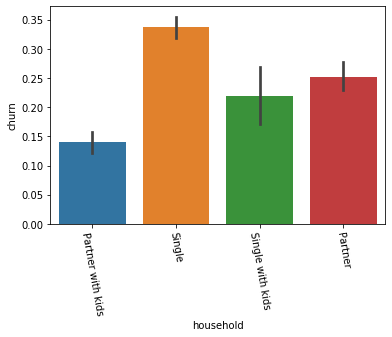

In [48]:
sns.barplot(x="household", y="churn", data=train1)
plt.xticks(rotation=-80)
plt.show()

> Single people are more likely to churn. Surely there is some other way to explain this. 

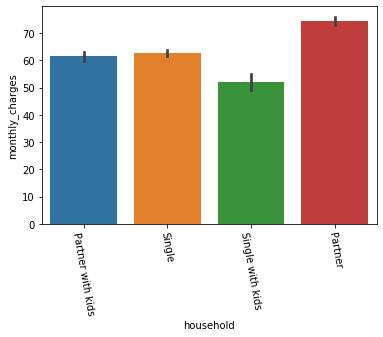

In [49]:
sns.barplot(x="household", y="monthly_charges", data=train1)
plt.xticks(rotation=-80)
plt.show()

> Everyone pays about the same amount. This implies that a single person is paying more per person that someone with a partner or kids.

##### Explore - paying more than x% of customers with the same services

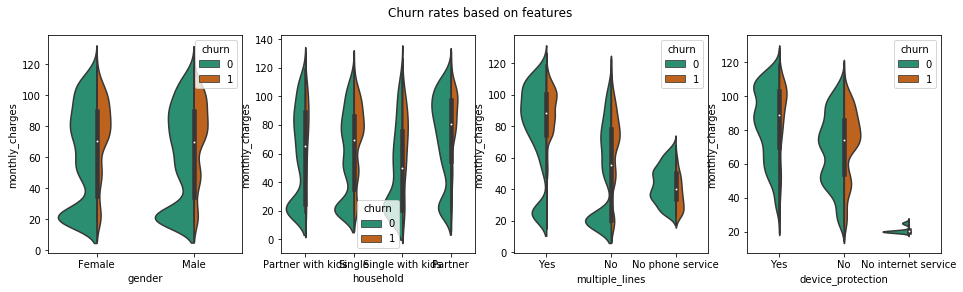

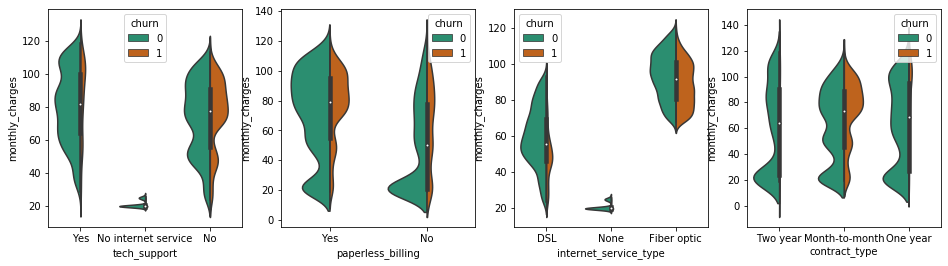

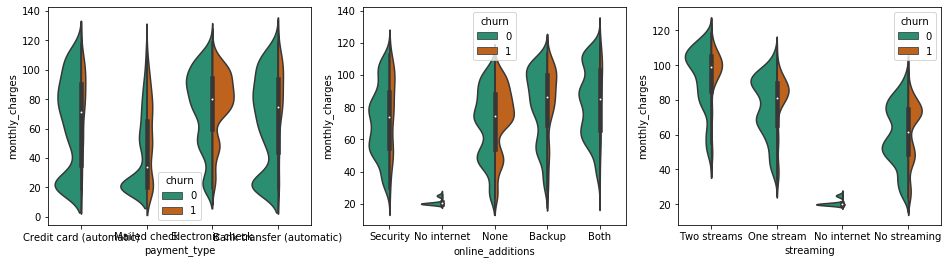

In [50]:
# plotting all the objects on a violin plot
features = ['gender', 'household', 'multiple_lines','device_protection']
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
for i, feature in enumerate(features):
    sns.violinplot(feature, 'monthly_charges', hue='churn', data=train1, split=True, ax=ax[i], palette="Dark2", scale="count")

plt.suptitle('Churn rates based on features')

features = ['tech_support', 'paperless_billing', 'internet_service_type', 'contract_type']
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
for i, feature in enumerate(features):
    sns.violinplot(feature, 'monthly_charges', hue='churn', data=train1, split=True, ax=ax[i], palette="Dark2", scale="count")
    
features = ['payment_type', 'online_additions', 'streaming']
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
for i, feature in enumerate(features):
    sns.violinplot(feature, 'monthly_charges', hue='churn', data=train1, split=True, ax=ax[i], palette="Dark2", scale="count")

plt.show()

Q3. Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?

In [51]:
print("The rate of churn at various price points for multiple lines:")
for x in range(18, 119, 10):
    print(x, train1 [(train1.multiple_lines == "Yes") & 
                     (train1.monthly_charges >= x) & (train1.monthly_charges < x+10) ].churn.mean())
print()
print("The rate of churn at various price points for one line:")
for x in range(18, 119, 10):
    print(x, train1 [(train1.multiple_lines == "No") & 
                     (train1.monthly_charges >= x) & (train1.monthly_charges < x+10) ].churn.mean())
print()
print("The rate of churn at various price points for device protection:")
for x in range(18, 119, 10):
    print(x, train1 [(train1.device_protection == "Yes") & 
                     (train1.monthly_charges >= x) & (train1.monthly_charges < x+10) ].churn.mean())
print()
print("The rate of churn at various price points for tech support:")
for x in range(18, 119, 10):
    print(x, train1 [(train1.tech_support == "Yes") & 
                     (train1.monthly_charges >= x) & (train1.monthly_charges < x+10) ].churn.mean())
print()
print("The rate of churn at various price points for dsl:")
for x in range(18, 119, 10):
    print(x, train1 [(train1.internet_service_type == "DSL") & 
                     (train1.monthly_charges >= x) & (train1.monthly_charges < x+10) ].churn.mean())    
print()
print("The rate of churn at various price points for fiber optic:")
for x in range(18, 119, 10):
    print(x, train1 [(train1.internet_service_type == "Fiber optic") & 
                     (train1.monthly_charges >= x) & (train1.monthly_charges < x+10) ].churn.mean())
print()
print("The rate of churn at various price points for security:")
for x in range(18, 119, 10):
    print(x, train1 [(train1.online_additions == "Security") & 
                     (train1.monthly_charges >= x) & (train1.monthly_charges < x+10) ].churn.mean())
print()
print("The rate of churn at various price points for backup:")
for x in range(18, 119, 10):
    print(x, train1 [(train1.online_additions == "Backup") & 
                     (train1.monthly_charges >= x) & (train1.monthly_charges < x+10) ].churn.mean())
print()
print("The rate of churn at various price points for security and backup:")
for x in range(18, 119, 10):
    print(x, train1 [(train1.online_additions == "Both") & 
                     (train1.monthly_charges >= x) & (train1.monthly_charges < x+10) ].churn.mean())
print()
print("The rate of churn at various price points for two streams:")
for x in range(18, 119, 10):
    print(x, train1 [(train1.streaming == "Two streams") & 
                     (train1.monthly_charges >= x) & (train1.monthly_charges < x+10) ].churn.mean())
print()
print("The rate of churn at various price points for one stream:")
for x in range(18, 119, 10):
    print(x, train1 [(train1.streaming == "One stream") & 
                     (train1.monthly_charges >= x) & (train1.monthly_charges < x+10) ].churn.mean())

The rate of churn at various price points for multiple lines:
18 0.02631578947368421
28 nan
38 1.0
48 0.26506024096385544
58 0.13274336283185842
68 0.3333333333333333
78 0.35141509433962265
88 0.32229580573951433
98 0.401673640167364
108 0.16532258064516128
118 0.16666666666666666

The rate of churn at various price points for one line:
18 0.08902691511387163
28 nan
38 0.42657342657342656
48 0.271523178807947
58 0.08717948717948718
68 0.4078341013824885
78 0.3932926829268293
88 0.41150442477876104
98 0.2692307692307692
108 0.3333333333333333
118 nan

The rate of churn at various price points for device protection:
18 nan
28 0.08571428571428572
38 0.24242424242424243
48 0.20245398773006135
58 0.08888888888888889
68 0.13440860215053763
78 0.19614147909967847
88 0.240625
98 0.3671497584541063
108 0.16393442622950818
118 0.16666666666666666

The rate of churn at various price points for tech support:
18 nan
28 0.14814814814814814
38 0.07936507936507936
48 0.16352201257861634
58 0.101382488

- multiple lines: churn jumps from .13 to .33 between 58 and 68 dollars
- one line: churn jumps from from .08 to .40 between 58 and 68 dollars

- device protection: churn jumps from .24 to .36 between 88 and 98 dollars
- tech support: churn jumps from .14 to .28 between 88 and 98 dollars

- dsl: no increase in churn
- fiber optic: no increase in churn

- security: churn jumps from .16 to .28 between 78 and 88 dollars
- security and backup: churn jumps from .10 to .17 between 88 and 98 dollars

- two streams: churn jumps from 0.03 to .42 between 78 and 88 dollars
- one stream: churn jumps from .05 to .56 between 68 and 78 dollars


Q4. If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

In [52]:
print('The churn rate after 12 months for a month-to-month contract:')
print(f'{train1 [(train1.tenure > 12) & (train1.contract_type == "Month-to-month")].churn.mean():.2}')
print('The churn rate after 12 months for a one-year contract:')
print(f'{train1 [(train1.tenure > 12) & (train1.contract_type == "One year")].churn.mean():.2}')

The churn rate after 12 months for a month-to-month contract:
0.33
The churn rate after 12 months for a one-year contract:
0.11


>The churn rate for month-to-month is still much higher than a one-year contract. Therefore, we must incentivize people to get into contracts

Q5. Controlling for services (phone_id, internet_service_type_id, online_security_backup, device_protection, tech_support, and contract_type_id), is the mean monthly_charges of those who have churned significantly different from that of those who have not churned? (Use a t-test to answer this.)

H0: the mean of monthly charges of churned folks is independent of the mean of monthly charges of not churned folks

##### Controlling for phone lines

In [53]:
stats.ttest_ind((train1[(train1.churn == 0) & (train1.multiple_lines == "No")]).monthly_charges, 
                (train1[(train1.churn == 1) & (train1.multiple_lines == "No")]).monthly_charges)

Ttest_indResult(statistic=-13.972136582588629, pvalue=6.651038271664591e-43)

In [54]:
stats.ttest_ind((train1[(train1.churn == 0) & (train1.multiple_lines == "Yes")]).monthly_charges, 
                (train1[(train1.churn == 1) & (train1.multiple_lines == "Yes")]).monthly_charges)

Ttest_indResult(statistic=-8.635977256932215, pvalue=1.0591234393120786e-17)

In [55]:
stats.ttest_ind((train1[(train1.churn == 0) & (train1.multiple_lines == "No phone service")]).monthly_charges, 
                (train1[(train1.churn == 1) & (train1.multiple_lines == "No phone service")]).monthly_charges)

Ttest_indResult(statistic=5.408035887236937, pvalue=9.529802114323164e-08)

##### Controlling for internet service type

In [56]:
stats.ttest_ind((train1[(train1.churn == 0) & (train1.internet_service_type == "Fiber optic")]).monthly_charges, 
                (train1[(train1.churn == 1) & (train1.internet_service_type == "Fiber optic")]).monthly_charges)

Ttest_indResult(statistic=11.174526538312383, pvalue=2.574999761370781e-28)

In [57]:
stats.ttest_ind((train1[(train1.churn == 0) & (train1.internet_service_type == "DSL")]).monthly_charges, 
                (train1[(train1.churn == 1) & (train1.internet_service_type == "DSL")]).monthly_charges)

Ttest_indResult(statistic=12.052013907764021, pvalue=2.66408097721226e-32)

In [58]:
stats.ttest_ind((train1[(train1.churn == 0) & (train1.internet_service_type == "None")]).monthly_charges, 
                (train1[(train1.churn == 1) & (train1.internet_service_type == "None")]).monthly_charges)

Ttest_indResult(statistic=3.6984136648525956, pvalue=0.00022651775662081426)

##### Controlling for device protection

In [59]:
stats.ttest_ind((train1[(train1.churn == 0) & (train1.device_protection == "No")]).monthly_charges, 
                (train1[(train1.churn == 1) & (train1.device_protection == "No")]).monthly_charges)

Ttest_indResult(statistic=-5.203548558393126, pvalue=2.1162693021810633e-07)

In [60]:
stats.ttest_ind((train1[(train1.churn == 0) & (train1.device_protection == "Yes")]).monthly_charges, 
                (train1[(train1.churn == 1) & (train1.device_protection == "Yes")]).monthly_charges)

Ttest_indResult(statistic=-4.502526963881925, pvalue=7.1174943361883274e-06)

##### Controlling for tech support

In [61]:
stats.ttest_ind((train1[(train1.churn == 0) & (train1.tech_support == "No")]).monthly_charges, 
                (train1[(train1.churn == 1) & (train1.tech_support == "No")]).monthly_charges)

Ttest_indResult(statistic=-3.890880425709156, pvalue=0.00010221970524963865)

In [62]:
stats.ttest_ind((train1[(train1.churn == 0) & (train1.tech_support == "Yes")]).monthly_charges, 
                (train1[(train1.churn == 1) & (train1.tech_support == "Yes")]).monthly_charges)

Ttest_indResult(statistic=-3.8505938021166846, pvalue=0.0001224665330645207)

##### Controlling for contract type

In [63]:
stats.ttest_ind((train1[(train1.churn == 0) & (train1.contract_type == "Month-to-month")]).monthly_charges, 
                (train1[(train1.churn == 1) & (train1.contract_type == "Month-to-month")]).monthly_charges)

Ttest_indResult(statistic=-12.03418445027, pvalue=1.2514015909350454e-32)

In [64]:
stats.ttest_ind((train1[(train1.churn == 0) & (train1.contract_type == "Two year")]).monthly_charges, 
                (train1[(train1.churn == 1) & (train1.contract_type == "Two year")]).monthly_charges)

Ttest_indResult(statistic=-4.857902812293882, pvalue=1.324611369409835e-06)

In [65]:
stats.ttest_ind((train1[(train1.churn == 0) & (train1.contract_type == "One year")]).monthly_charges, 
                (train1[(train1.churn == 1) & (train1.contract_type == "One year")]).monthly_charges)

Ttest_indResult(statistic=-7.647280529096196, pvalue=4.2304015033662194e-14)

> The p-values are all basically zero, therefore, the null hypothesis is rejected

Q6. How much of monthly_charges can be explained by internet_service_type? (hint: correlation test). State your hypotheses and your conclusion clearly.

H0: monthly_charges are independent of internet_service_type

In [66]:
observed = pd.crosstab(train1.monthly_charges,train1.internet_service_type)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print('Observed')
print(observed.values)
print('\nExpected')
print(expected)
print('')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[0 0 1]
 [0 0 1]
 [0 0 2]
 ...
 [0 2 0]
 [0 1 0]
 [0 1 0]]

Expected
[[0.34275556 0.43822222 0.21902222]
 [0.34275556 0.43822222 0.21902222]
 [0.68551111 0.87644444 0.43804444]
 ...
 [0.68551111 0.87644444 0.43804444]
 [0.34275556 0.43822222 0.21902222]
 [0.34275556 0.43822222 0.21902222]]

chi^2 = 9502.6892
p     = 0.0000


> The p-value is zero, therefore, we reject the null hypothesis that monthly charges and internet service type are independent

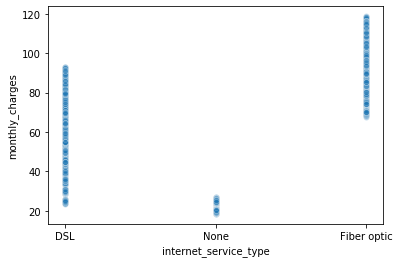

In [67]:
sns.scatterplot(x="internet_service_type", y="monthly_charges", data=train1, alpha=.3)
plt.show()

> There appears to be a high correlation between monthly charges and internet service type. Do these features need to be combined? Drop service type?

Q7. How much of monthly_charges can be explained by internet_service_type + phone service type (0, 1, or multiple lines). State your hypotheses and your conclusion clearly.

H0: internet service type and phone service type are independent of each other

In [102]:
observed = pd.crosstab(train1.internet_service_type, train1.multiple_lines)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print('Observed')
print(observed.values)
print('\nExpected')
print(expected)
print('')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[ 846  550  532]
 [ 924    0 1541]
 [ 966    0  266]]

Expected
[[ 937.7792      188.51555556  801.70524444]
 [1198.976       241.02222222 1025.00177778]
 [ 599.2448      120.46222222  512.29297778]]

chi^2 = 1820.0546
p     = 0.0000


> The p-value is zero, therefore, we reject the null hypothesis that they are independent of each other

Q8. Create visualizations exploring the interactions of variables (independent with independent and independent with dependent). The goal is to identify features that are related to churn, identify any data integrity issues, understand 'how the data works'. For example, we may find that all who have online services also have device protection. In that case, we don't need both of those. (The visualizations done in your analysis for questions 1-5 count towards the requirements below)

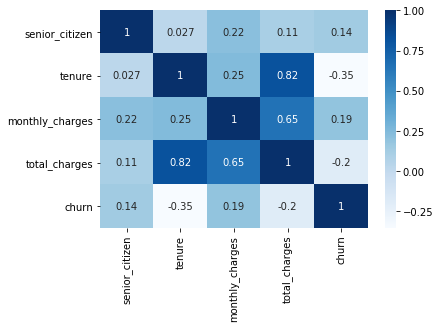

In [69]:
#show the correlation of continuous features
sns.heatmap(train1.corr(), cmap='Blues', annot=True)
plt.show()

Q9. What can you say about each variable's relationship to churn, based on your initial exploration? If there appears to be some sort of interaction or correlation, assume there is no causal relationship and brainstorm (and document) ideas on reasons there could be correlation

- Tenure: People churn at higher rates in the earlier months. This could be due to being pulled in at a promotional rate for a month or so, and then they leave after the promotion is over.  
- Payment_type: Electronic checks overwhelming have the highest churn rate. Mailed checks have a the second highest, but drops to about half of that rate. Both automatic payments have lower churn rates, as it's easier to pay something when you don't have to think about it. 
- Phone lines: There doesn't appear to be correlation between the number of phone lines and churn.
- Online_additions: People with no online additions are more likely to churn. People could be finding the online benefits with other companies at a cheaper price. Or people could feel much more secure in their browsing with the addition of security and backup and therefore are more likely to stay.
- Senior citizen: Senior citizens churn at a higher rate. It could be due to them having higher monthly charges, or just them not interested in being as connected as the younger generation, and finds a more basic company. 
- Streaming services: If a customer has internet, there appears to be no correlation between streaming services and churn. 
- Household: Single people are churning at higher rates than people with partners or kids. It appears single people and people with families have about the same monthly rate. Perhaps the price per person is too high for just one person, and the package deals are more affordable. 

Q10. Summarize your conclusions, provide clear answers to the specific questions, and summarize any takeaways/action plan from the work above.

- Target: churn

- Fields to include: tenure, payment_type, online_additions, monthly_charges, senior_citizen
- Fields to drop: multiple_lines, streaming, household, internet_service_type
- Fields ignored: customer_id, gender, device_protection, tech_support, paperless_billing
- Fields to consider: total_charges

Included fields are the features that we should focus on to reduce churn. 
    - tenure: the longer a customer is with the company, the more likely they are to stay
    - payment_type: customers with autopayments are more likely to stay
    - online_additions: customers with online security or backup are more likely to stay
    - monthly_charges: there is a price point for specific features that increase churn
    - senior_citizen: senior citizens leave at a higher rate, it is currently unknown why

In [70]:
# selected features
features = ["senior_citizen","tenure", "payment_type", "online_additions", "monthly_charges","total_charges"]
# features = ["senior_citizen","tenure", "payment_type", "online_additions", "monthly_charges"]

### Prepare - MVP 

In [71]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5625 entries, 5474 to 3582
Data columns (total 17 columns):
customer_id              5625 non-null object
gender                   5625 non-null object
senior_citizen           5625 non-null int64
tenure                   5625 non-null int64
multiple_lines           5625 non-null object
device_protection        5625 non-null object
tech_support             5625 non-null object
paperless_billing        5625 non-null object
monthly_charges          5625 non-null float64
total_charges            5625 non-null float64
churn                    5625 non-null int64
internet_service_type    5625 non-null object
contract_type            5625 non-null object
payment_type             5625 non-null object
online_additions         5625 non-null object
streaming                5625 non-null object
household                5625 non-null object
dtypes: float64(2), int64(3), object(12)
memory usage: 951.0+ KB


In [72]:
# split into X and y dataframes
X_train1 = train1.drop(columns = "churn")
X_test1 = test1.drop(columns = "churn")
y_train1 = train1[["churn"]]
y_test1 = test1[["churn"]]

In [73]:
# apply selected features
X_train1 = X_train1[features]
X_test1 = X_test1[features]
X_train1.head()

,senior_citizen,tenure,payment_type,online_additions,monthly_charges,total_charges
5474,0,72,Credit card (automatic),Security,85.90,6110.75
5426,0,62,Mailed check,Security,65.10,3846.75
3563,0,1,Electronic check,No internet,20.00,20.00
2096,0,33,Bank transfer (automatic),None,70.40,2406.10
7019,0,56,Mailed check,No internet,24.45,1385.85


In [74]:
# one hot encode category data so it can be run in models
X_train1, X_test1 = prep.encode_hot(X_train1, X_test1, col_name = 'payment_type')
X_train1, X_test1 = prep.encode_hot(X_train1, X_test1, col_name = 'online_additions')

In [75]:
# remove old categories
X_train1.drop(columns=["payment_type","online_additions"], inplace=True)
X_test1.drop(columns=["payment_type","online_additions"], inplace=True)

In [76]:
X_train1.head()

,senior_citizen,tenure,monthly_charges,total_charges,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Backup,Both,No internet,None,Security
5474,0,72,85.90,6110.75,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5426,0,62,65.10,3846.75,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3563,0,1,20.00,20.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2096,0,33,70.40,2406.10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7019,0,56,24.45,1385.85,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Model - MVP - logistic regression

In [77]:
# run logistic regression model! 
logit, y_pred, y_pred_proba = model.logit(X_train1, y_train1)

In [78]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train1, y_train1)))
print()
print("confusion matrix")
print(confusion_matrix(y_train1, y_pred))
print()
print(classification_report(y_train1, y_pred))

Accuracy of Logistic Regression classifier on training set: 0.71

confusion matrix
[[2908 1242]
 [ 392 1083]]

              precision    recall  f1-score   support

           0       0.88      0.70      0.78      4150
           1       0.47      0.73      0.57      1475

    accuracy                           0.71      5625
   macro avg       0.67      0.72      0.68      5625
weighted avg       0.77      0.71      0.73      5625



### Model - MVP - decision tree

In [80]:
# run decision tree!
clf, y_pred, y_pred_proba = model.clf(X_train1, y_train1)

In [81]:
clf.feature_importances_

array([0.        , 0.459271  , 0.29983364, 0.03872041, 0.        ,
       0.        , 0.11601638, 0.        , 0.        , 0.        ,
       0.        , 0.08615856, 0.        ])

In [82]:
names = pd.DataFrame(X_train1.columns, columns=['column'])
names['importance'] = clf.feature_importances_
names.sort_values(by='importance', ascending=False)

,column,importance
1,tenure,0.459271
2,monthly_charges,0.299834
6,Electronic check,0.116016
11,None,0.086159
3,total_charges,0.038720
0,senior_citizen,0.000000
4,Bank transfer (automatic),0.000000
5,Credit card (automatic),0.000000
7,Mailed check,0.000000
8,Backup,0.000000


In [83]:
print('Accuracy of decision tree classifier on training set: {:.2f}'
     .format(clf.score(X_train1, y_train1)))
print()
print("confusion matrix")
print(confusion_matrix(y_train1, y_pred))
print()
print(classification_report(y_train1, y_pred))

Accuracy of decision tree classifier on training set: 0.79

confusion matrix
[[3838  312]
 [ 883  592]]

              precision    recall  f1-score   support

           0       0.81      0.92      0.87      4150
           1       0.65      0.40      0.50      1475

    accuracy                           0.79      5625
   macro avg       0.73      0.66      0.68      5625
weighted avg       0.77      0.79      0.77      5625



In [84]:
# visualize
dot_data = export_graphviz(clf, out_file=None, feature_names=X_train1.columns) 
graph = Source(dot_data) 

graph.render('telco_decision_tree', view=True)

'telco_decision_tree.pdf'

### Model - MVP - random forest 

In [86]:
# run random forest! 
rf, y_pred, y_pred_proba = model.rf(X_train1, y_train1)

In [87]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train1, y_train1)))
print()
print("confusion matrix")
print(confusion_matrix(y_train1, y_pred))
print()
print(classification_report(y_train1, y_pred))

Accuracy of random forest classifier on training set: 0.79

confusion matrix
[[3972  178]
 [1013  462]]

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      4150
           1       0.72      0.31      0.44      1475

    accuracy                           0.79      5625
   macro avg       0.76      0.64      0.65      5625
weighted avg       0.78      0.79      0.76      5625



### Model - MVP - knn

In [89]:
# run k-nearest neighbor! 
knn, y_pred, y_pred_proba = model.knn(X_train1, y_train1)

In [90]:
print('Accuracy of k-nearest neighbor classifier on training set: {:.2f}'
     .format(knn.score(X_train1, y_train1)))
print()
print("confusion matrix")
print(confusion_matrix(y_train1, y_pred))
print()
print(classification_report(y_train1, y_pred))

Accuracy of k-nearest neighbor classifier on training set: 0.83

confusion matrix
[[4024  126]
 [ 803  672]]

              precision    recall  f1-score   support

           0       0.83      0.97      0.90      4150
           1       0.84      0.46      0.59      1475

    accuracy                           0.83      5625
   macro avg       0.84      0.71      0.74      5625
weighted avg       0.84      0.83      0.82      5625



> The KNN has the best accuracy and the lowest False Negative count, so it was selected as the final model. 

### Test 

In [91]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test1, y_test1)))

Accuracy of KNN classifier on test set: 0.75


In [92]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test1, y_test1)))

Accuracy of Decision Tree classifier on test set: 0.77


> When the test data is run, the accuracy for the KNN model dropped from .83 to .75. Therefore, the model overfit the data. 
> The decision tree is now selected as the final model, as it does not appear to overfit the data.

### Create CSV file with selected model

In [93]:
# recreate decision tree model
clf, y_pred, y_pred_proba = model.clf(X_train1, y_train1)

In [95]:
# create dataframes with the indexes
df_y_pred = pd.DataFrame(y_pred).set_index(X_train1.index)
df_y_pred_proba = pd.DataFrame(y_pred_proba).set_index(X_train1.index)
df_id = train1[["customer_id"]]

In [96]:
# merge the three dfs together
df_y = pd.merge(df_y_pred_proba, df_y_pred, left_index=True, right_index=True)
df_y = pd.merge(df_id, df_y, left_index=True, right_index=True)

In [97]:
# rename columns
df_y.rename(columns = {'0_x': 'Prob of 0', 1:'Prob of 1','0_y':'Churn'}, inplace=True)

In [99]:
df_y.head(20)

,customer_id,Prob of 0,Prob of 1,Churn
5474,2226-ICFDO,0.843072,0.156928,0
5426,1221-GHZEP,0.954418,0.045582,0
3563,3807-XHCJH,0.804677,0.195323,0
2096,4067-HLYQI,0.954418,0.045582,0
7019,9593-CVZKR,0.954418,0.045582,0
2399,5380-WJKOV,0.640514,0.359486,0
4929,8947-YRTDV,0.843072,0.156928,0
5043,1776-SPBWV,0.954418,0.045582,0
5241,7009-PCARS,0.954418,0.045582,0
847,6888-SBYAI,0.804677,0.195323,0


In [100]:
df_y.to_csv (r'/Users/mists/codeup-data-science/telco-project/telco_churn.csv', header=True)